In [2]:
!python print("Hello, World!")

SyntaxError: invalid syntax (2783294118.py, line 1)

In [3]:
import os
from math import log10
import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.utils.data import DataLoader
from tqdm import tqdm
import pytorch_ssim
from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from loss import GeneratorLoss
from model import Generator, Discriminator

# Default values
CROP_SIZE = 88
UPSCALE_FACTOR = 4
NUM_EPOCHS = 100

# Paths to the datasets
train_set = TrainDatasetFromFolder('/home/dst/Desktop/GAN/SRGAN/data/wavlet/LL', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder('/home/dst/Desktop/GAN/SRGAN/data/wavlet/LL_val', upscale_factor=UPSCALE_FACTOR)

# DataLoaders
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

# Initialize model and loss
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()
generator_criterion = GeneratorLoss()

# Check if GPU is available
if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

# Optimizers
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

# Results dictionary
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': [], 'loss_ratio': [], 'learning_rate': [], 'fid': []}

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = target
        if torch.cuda.is_available():
            real_img = real_img.float().cuda()
        z = data
        if torch.cuda.is_available():
            z = z.float().cuda()
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        optimizerG.step()

        real_out = netD(real_img).mean()
        fake_out = netD(fake_img.detach()).mean()
        d_loss = 1 - real_out + fake_out

        optimizerD.zero_grad()
        d_loss.backward()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerD.step()

        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    
    # Validation
    netG.eval()
    out_path = 'training_results/SRF_'+ str(UPSCALE_FACTOR) + 'X_LL' + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        index = 1
        saved_images = 0  
        max_saved_images = 50  

        for val_lr, val_hr_restore, val_hr in val_bar:
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size

            lr = val_lr.cuda() if torch.cuda.is_available() else val_lr
            hr = val_hr.cuda() if torch.cuda.is_available() else val_hr
            sr = netG(lr)

            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size

            batch_ssim = pytorch_ssim.ssim(sr, hr).item()
            valing_results['ssims'] += batch_ssim * batch_size

            valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']

            val_bar.set_description(desc=f'[Converting LR to SR] PSNR: {valing_results["psnr"]:.4f} dB SSIM: {valing_results["ssim"]:.4f}')

            for i in range(batch_size):
                if saved_images >= max_saved_images:  
                    break

                sr_image = display_transform()(sr[i].cpu())
                hr_image = display_transform()(hr[i].cpu())
                lr_image = display_transform()(val_hr_restore[i])

                grid = utils.make_grid([lr_image, hr_image, sr_image], nrow=3, padding=5)
                utils.save_image(grid, os.path.join(out_path, f'epoch_{epoch}_index_{index}.png'), padding=5)

                index += 1
                saved_images += 1  

                if saved_images >= max_saved_images:  
                    break

    # Save models
    torch.save(netG.state_dict(), 'epochs/LL/netG_LL_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
    torch.save(netD.state_dict(), 'epochs/LL/netD_LL_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))

    # Collect results
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])
    results['loss_ratio'].append((running_results['g_loss'] / running_results['batch_sizes']) / (running_results['d_loss'] / running_results['batch_sizes']))
    results['learning_rate'].append(optimizerG.param_groups[0]['lr'])

    # Save statistics every 10 epochs
    if epoch % 10 == 0:
        out_path = 'statistics/'
        os.makedirs(out_path, exist_ok=True)
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                  'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim'],
                  'Loss_Ratio': results['loss_ratio'], 'Learning_Rate': results['learning_rate']},
            index=range(1, epoch + 1))
        data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + 'x_LL' + '_train_results.csv', index_label='Epoch')


/home/dst/anaconda3/envs/srgan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dst/anaconda3/envs/srgan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/113 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 9, 9], expected input[64, 1, 22, 22] to have 3 channels, but got 1 channels instead

In [1]:
import cv2 
import numpy as np
import os

In [2]:
img = cv2.imread('/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/image_013_rotate..jpg')

In [28]:
#print the values of the image
print(img)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [3]:
img.shape


(512, 512, 3)

In [4]:
#view range
img.max(), img.min()
#view image


(255, 0)

In [25]:
from PIL import Image
path = '/home/dst/Desktop/GAN/SRGAN/data/wavlet/LL_val/image_3445_rotate_LL.png'
imgr = Image.open(path).convert("RGB")  # Convert grayscale to RGB


In [17]:
cv2_disp('image', img)
cv2.waitKey(0)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


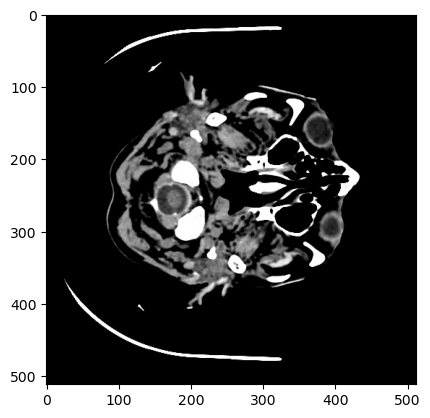

In [26]:
import matplotlib.pyplot as plt
plt.imshow(img)

/tmp/ipykernel_4249/3638111804.py:4: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.507983323896435..232.73169072397533].


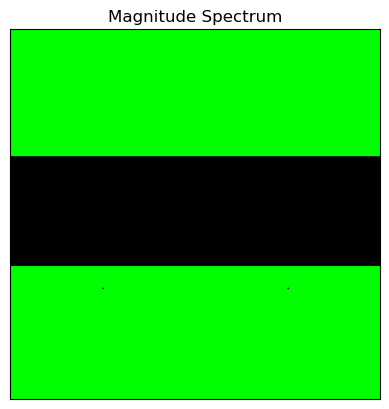

In [27]:
#do fourier transform
f = np.fft.fft2(imgr)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.00000000000006].


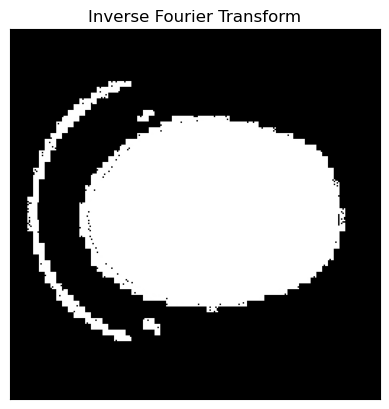

In [29]:
#do inverse fourier transform
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
plt.imshow(img_back)
plt.title('Inverse Fourier Transform'), plt.xticks([]), plt.yticks([])
plt.show()

(255, 0)

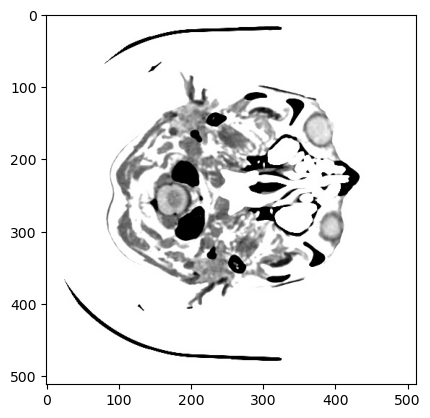

In [18]:
#invert the image
img_inv = 255 - img
plt.imshow(img_inv)
#view range
img_inv.max(), img_inv.min()

In [21]:
path_img="/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/image_013_rotate..jpg"
img = Image.open(path_img).convert("RGB")

In [32]:
img.shape

(512, 512, 3)

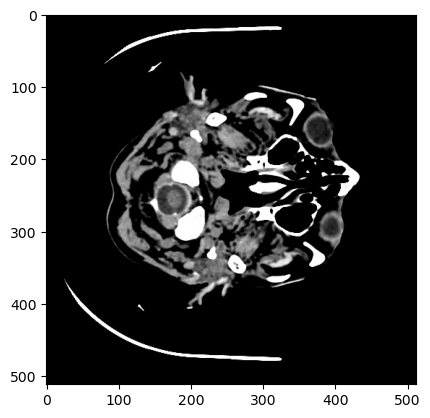

In [33]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [34]:
#wavlet transform
import pywt
coeffs2 = pywt.dwt2(img, 'db1')  # You can change 'haar' to other wavelets like 'db1', 'db2', etc.
LL, (LH, HL, HH) = coeffs2


In [36]:
import cv2

# Load the image in grayscale mode
img = cv2.imread('/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/image_013_rotate..jpg', cv2.IMREAD_GRAYSCALE)

# Check shape
print(img.shape)  # Should be (H, W), not (H, W, C)

# Perform DWT
coeffs2 = pywt.dwt2(img, 'db1')
LL, (LH, HL, HH) = coeffs2

# Check output shapes
print(LL.shape, LH.shape, HL.shape, HH.shape)  # Should be (H/2, W/2)


(512, 512)
(256, 256) (256, 256) (256, 256) (256, 256)


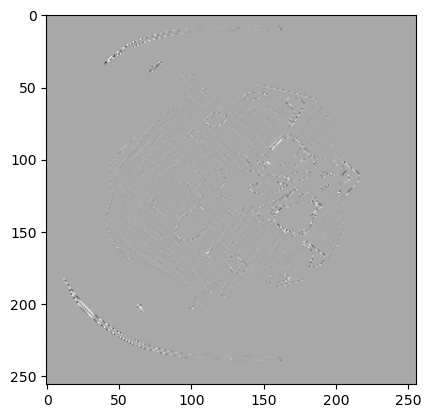

In [40]:
plt.imshow(HH, cmap='gray')

In [44]:

cv2.imwrite("HH.png", LL)

True

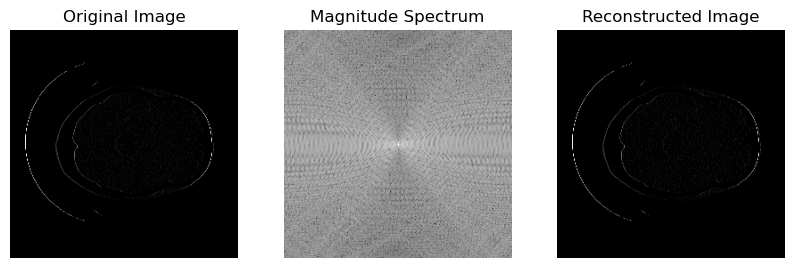

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fourier_transform(image_path):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  
    
    
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  
    
    f_ishift = np.fft.ifftshift(fshift)
    img_reconstructed = np.fft.ifft2(f_ishift)
    img_reconstructed = np.abs(img_reconstructed)  
    
  
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img_reconstructed, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.show()


image_path = '/home/dst/Desktop/GAN/SRGAN/data/wavlet/HL_val/image_3445_rotate_HL.png'  # Replace with your image path
fourier_transform(image_path)

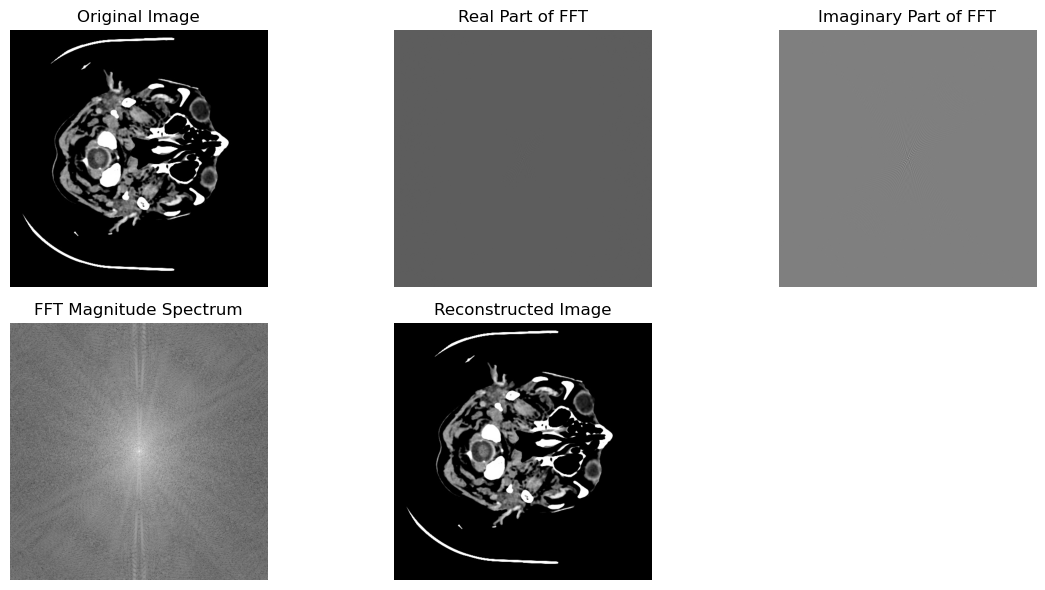

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_fft_ifft(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError("Image not found or unable to load.")
    
    # Compute the 2D Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center
    
    # Extract real and imaginary parts
    real_part = np.real(fshift)
    imag_part = np.imag(fshift)
    
    # Reconstruct from real and imaginary parts
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)  # Shift back
    img_reconstructed = np.fft.ifft2(ifshift).real  # Take real part of IFFT
    cv2.imwrite("real_img1.png", real_part)
    cv2.imwrite("imag_img1.png", imag_part)
    
    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(real_part, cmap='gray')
    plt.title('Real Part of FFT')
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Imaginary Part of FFT')
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(np.log(1 + np.abs(fshift)), cmap='gray')
    plt.title('FFT Magnitude Spectrum')
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(img_reconstructed, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/image_013_rotate..jpg'  # Replace with your image path
test_fft_ifft(image_path)

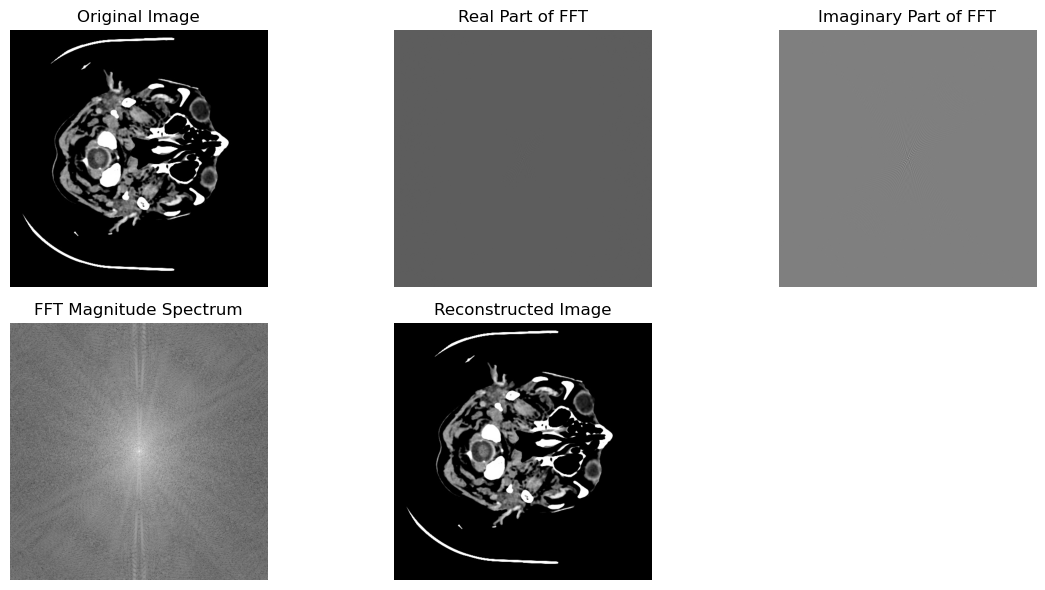

In [55]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_fft_ifft(image_path, save_path_real='real_part.png', save_path_imag='imag_part.png', save_path_reconstructed='reconstructed.png'):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError("Image not found or unable to load.")
    
    # Compute the 2D Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center
    
    # Extract real and imaginary parts
    real_part = np.real(fshift)
    imag_part = np.imag(fshift)
    
    # Normalize for saving
    real_part_norm = cv2.normalize(real_part, None, 0, 255, cv2.NORM_MINMAX)
    imag_part_norm = cv2.normalize(imag_part, None, 0, 255, cv2.NORM_MINMAX)
    
    # Save real and imaginary parts as images
    cv2.imwrite(save_path_real, real_part_norm)
    cv2.imwrite(save_path_imag, imag_part_norm)
    
    # Reconstruct from real and imaginary parts
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)  # Shift back
    img_reconstructed = np.fft.ifft2(ifshift).real  # Take real part of IFFT
    
    # Normalize and save reconstructed image
    img_reconstructed_norm = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(save_path_reconstructed, img_reconstructed_norm)
    
    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(real_part, cmap='gray')
    plt.title('Real Part of FFT')
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Imaginary Part of FFT')
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(np.log(1 + np.abs(fshift)), cmap='gray')
    plt.title('FFT Magnitude Spectrum')
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(img_reconstructed, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/image_013_rotate..jpg'  # Replace with your image path
test_fft_ifft(image_path)


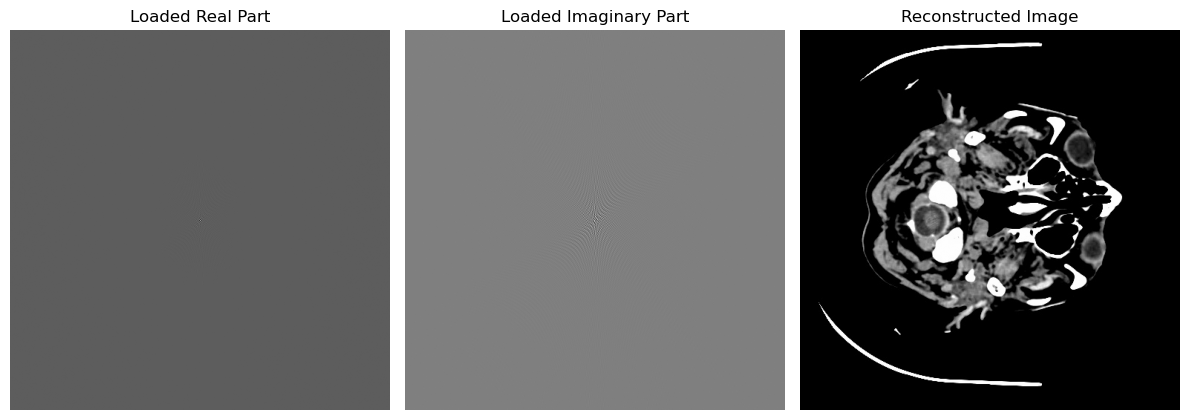

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_fft_components(image_path, save_path_real='real_part.npy', save_path_imag='imag_part.npy'):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError("Image not found or unable to load.")
    
    # Compute the 2D Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center
    
    # Extract real and imaginary parts
    real_part = np.real(fshift)
    imag_part = np.imag(fshift)
    
    # Save real and imaginary parts as numpy arrays
    np.save(save_path_real, real_part)
    np.save(save_path_imag, imag_part)

def reconstruct_from_saved_fft(real_path='real_part.npy', imag_path='imag_part.npy', save_path_reconstructed='reconstructed.png'):
    # Load saved real and imaginary parts
    real_part = np.load(real_path)
    imag_part = np.load(imag_path)
    
    # Reconstruct from real and imaginary parts
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)  # Shift back
    img_reconstructed = np.fft.ifft2(ifshift).real  # Take real part of IFFT
    
    # Normalize and save reconstructed image
    img_reconstructed_norm = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
    img_reconstructed_norm = np.uint8(img_reconstructed_norm)
    cv2.imwrite(save_path_reconstructed, img_reconstructed_norm)
    
    # Display results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(real_part, cmap='gray')
    plt.title('Loaded Real Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Loaded Imaginary Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img_reconstructed_norm, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/image_013_rotate..jpg'  # Replace with your image path'
save_fft_components(image_path)
reconstruct_from_saved_fft()


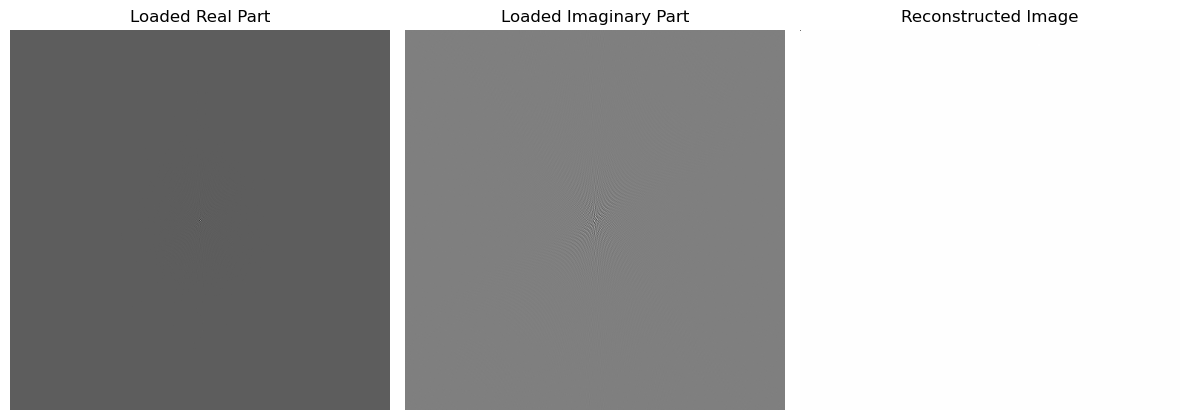

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def save_fft_components(image_path, save_path_real='real_part.png', save_path_imag='imag_part.png'):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError("Image not found or unable to load.")
    
    # Compute the 2D Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center
    
    # Extract real and imaginary parts
    real_part = np.real(fshift)
    imag_part = np.imag(fshift)
    
    # Normalize and convert to 8-bit format
    real_part_norm = cv2.normalize(real_part, None, 0, 255, cv2.NORM_MINMAX)
    imag_part_norm = cv2.normalize(imag_part, None, 0, 255, cv2.NORM_MINMAX)
    real_part_norm = np.uint8(real_part_norm)
    imag_part_norm = np.uint8(imag_part_norm)
    
    # Save as images
    cv2.imwrite(save_path_real, real_part_norm)
    cv2.imwrite(save_path_imag, imag_part_norm)

def reconstruct_from_saved_fft(real_path='real_part.png', imag_path='imag_part.png', save_path_reconstructed='reconstructed.png'):
    # Load saved real and imaginary parts
    real_part = cv2.imread(real_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    imag_part = cv2.imread(imag_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    
    # Rescale back to original range
    real_part = cv2.normalize(real_part, None, -1, 1, cv2.NORM_MINMAX)
    imag_part = cv2.normalize(imag_part, None, -1, 1, cv2.NORM_MINMAX)
    
    # Reconstruct from real and imaginary parts
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)  # Shift back
    img_reconstructed = np.fft.ifft2(ifshift).real  # Take real part of IFFT
    
    # Normalize and save reconstructed image
    img_reconstructed_norm = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
    img_reconstructed_norm = np.uint8(img_reconstructed_norm)
    cv2.imwrite(save_path_reconstructed, img_reconstructed_norm)
    
    # Display results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(real_part, cmap='gray')
    plt.title('Loaded Real Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Loaded Imaginary Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img_reconstructed_norm, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/image_013_rotate..jpg'  # Replace with your image path
save_fft_components(image_path)
reconstruct_from_saved_fft()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence

def save_fft_components(image_path, save_path_real='real_part.npy', save_path_imag='imag_part.npy'):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError("Image not found or unable to load.")
    
    # Compute the 2D Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center
    
    # Extract real and imaginary parts
    real_part = np.real(fshift)
    imag_part = np.imag(fshift)
    
    # Save real and imaginary parts as numpy arrays
    np.save(save_path_real, real_part)
    np.save(save_path_imag, imag_part)

def reconstruct_from_saved_fft(real_path='real_part.npy', imag_path='imag_part.npy', save_path_reconstructed='reconstructed.png'):
    # Load saved real and imaginary parts
    real_part = np.load(real_path)
    imag_part = np.load(imag_path)
    
    # Reconstruct from real and imaginary parts
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)  # Shift back
    img_reconstructed = np.fft.ifft2(ifshift).real  # Take real part of IFFT
    
    # Normalize and save reconstructed image
    img_reconstructed_norm = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
    img_reconstructed_norm = np.uint8(img_reconstructed_norm)
    cv2.imwrite(save_path_reconstructed, img_reconstructed_norm)
    
    # Display results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(real_part, cmap='gray')
    plt.title('Loaded Real Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Loaded Imaginary Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img_reconstructed_norm, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class FFTImageDataset(Sequence):
    def __init__(self, image_paths, batch_size=32, img_size=(256, 256)):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        real_images = []
        imag_images = []
        
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)
            
            real_images.append(np.real(fshift))
            imag_images.append(np.imag(fshift))
        
        real_images = np.expand_dims(np.array(real_images), axis=-1)
        imag_images = np.expand_dims(np.array(imag_images), axis=-1)
        
        return [real_images, imag_images], real_images  # Example target, can be modified

# Example usage
image_path = 'your_image.jpg'  # Replace with your image path
save_fft_components(image_path)
reconstruct_from_saved_fft()

# Example dataset usage
image_paths = ['your_image.jpg']  # Replace with multiple paths for training
dataset = FFTImageDataset(image_paths)
for batch in dataset:
    (real_part, imag_part), target = batch
    print("Batch shapes:", real_part.shape, imag_part.shape, target.shape)
    break


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence

def save_fft_components_from_folder(folder_path, save_dir='fft_components'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        
        real_part = np.real(fshift)
        imag_part = np.imag(fshift)
        
        np.save(os.path.join(save_dir, filename + '_real.npy'), real_part)
        np.save(os.path.join(save_dir, filename + '_imag.npy'), imag_part)

def reconstruct_from_saved_fft(real_path, imag_path, save_path_reconstructed='reconstructed.png'):
    real_part = np.load(real_path)
    imag_part = np.load(imag_path)
    
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)
    img_reconstructed = np.fft.ifft2(ifshift).real
    
    img_reconstructed_norm = cv2.normalize(img_reconstructed, None, 0, 255, cv2.NORM_MINMAX)
    img_reconstructed_norm = np.uint8(img_reconstructed_norm)
    cv2.imwrite(save_path_reconstructed, img_reconstructed_norm)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(real_part, cmap='gray')
    plt.title('Loaded Real Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Loaded Imaginary Part')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img_reconstructed_norm, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class FFTImageDataset(Sequence):
    def __init__(self, folder_path, batch_size=32, img_size=(256, 256)):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        self.batch_size = batch_size
        self.img_size = img_size
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        real_images = []
        imag_images = []
        
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)
            
            real_images.append(np.real(fshift))
            imag_images.append(np.imag(fshift))
        
        real_images = np.expand_dims(np.array(real_images), axis=-1)
        imag_images = np.expand_dims(np.array(imag_images), axis=-1)
        
        return [real_images, imag_images], real_images

# Example usage
folder_path = 'your_folder'  # Replace with your folder path
save_fft_components_from_folder(folder_path)

# Example dataset usage
dataset = FFTImageDataset(folder_path)
for batch in dataset:
    (real_part, imag_part), target = batch
    print("Batch shapes:", real_part.shape, imag_part.shape, target.shape)
    break


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

def save_fft_components_from_folder(folder_path, save_dir='fft_components'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        
        real_part = np.real(fshift)
        imag_part = np.imag(fshift)
        
        np.save(os.path.join(save_dir, filename + '_real.npy'), real_part)
        np.save(os.path.join(save_dir, filename + '_imag.npy'), imag_part)

def reconstruct_from_saved_fft(real_path, imag_path):
    real_part = np.load(real_path)
    imag_part = np.load(imag_path)
    
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)
    img_reconstructed = np.fft.ifft2(ifshift).real
    
    return img_reconstructed

def display_images(original, real_part, imag_part, reconstructed):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(real_part, cmap='gray')
    plt.title('Real Part')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Imaginary Part')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(np.prod(input_shape), activation='linear')(x)
    x = Reshape(input_shape)(x)
    
    autoencoder = Model(input_layer, x)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Example usage
folder_path = 'your_folder'  # Replace with your folder path
save_fft_components_from_folder(folder_path)

# Load example image
sample_real = np.load('fft_components/sample_real.npy')
sample_imag = np.load('fft_components/sample_imag.npy')
original_image = np.fft.ifft2(np.fft.ifftshift(sample_real + 1j * sample_imag)).real

# Autoencoder training
input_shape = sample_real.shape + (1,)
autoencoder = build_autoencoder(input_shape)

x_train = np.expand_dims(sample_real, axis=-1)  # Use real part for training
autoencoder.fit(x_train, x_train, epochs=10, batch_size=1)

# Test reconstruction
reconstructed_real = autoencoder.predict(np.expand_dims(sample_real, axis=(0, -1)))[0, :, :, 0]
reconstructed_image = reconstruct_from_saved_fft(reconstructed_real, sample_imag)

# Display results
display_images(original_image, sample_real, sample_imag, reconstructed_image)


In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

data_folder = '/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/'
real_save_folder = os.path.join(data_folder, 'real_images')
imag_save_folder = os.path.join(data_folder, 'imag_images')

os.makedirs(real_save_folder, exist_ok=True)
os.makedirs(imag_save_folder, exist_ok=True)

def save_fft_components_from_folder(folder_path):
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        
        real_part = np.real(fshift)
        imag_part = np.imag(fshift)
        
        np.save(os.path.join(real_save_folder, filename + '_real.npy'), real_part)
        np.save(os.path.join(imag_save_folder, filename + '_imag.npy'), imag_part)

def reconstruct_from_saved_fft(real_path, imag_path):
    real_part = np.load(real_path)
    imag_part = np.load(imag_path)
    
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)
    img_reconstructed = np.fft.ifft2(ifshift).real
    
    return img_reconstructed

def display_images(original, real_part, imag_part, reconstructed):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(real_part, cmap='gray')
    plt.title('Real Part')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Imaginary Part')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(np.prod(input_shape), activation='linear')(x)
    x = Reshape(input_shape)(x)
    
    autoencoder = Model(input_layer, x)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Process dataset
save_fft_components_from_folder(data_folder)

# Load example image
example_filename = os.listdir(real_save_folder)[0].replace('_real.npy', '')
real_path = os.path.join(real_save_folder, example_filename + '_real.npy')
imag_path = os.path.join(imag_save_folder, example_filename + '_imag.npy')

sample_real = np.load(real_path)
sample_imag = np.load(imag_path)
original_image = np.fft.ifft2(np.fft.ifftshift(sample_real + 1j * sample_imag)).real

# Autoencoder training
input_shape = sample_real.shape + (1,)
autoencoder = build_autoencoder(input_shape)

x_train = np.expand_dims(sample_real, axis=-1)  # Use real part for training
autoencoder.fit(x_train, x_train, epochs=10, batch_size=1)

# Test reconstruction
reconstructed_real = autoencoder.predict(np.expand_dims(sample_real, axis=(0, -1)))[0, :, :, 0]
reconstructed_image = reconstruct_from_saved_fft(reconstructed_real, sample_imag)

# Display results
display_images(original_image, sample_real, sample_imag, reconstructed_image)

Epoch 1/10


2025-02-05 12:37:58.655157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-05 12:37:58.674188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-05 12:37:58.675416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-05 12:37:58.677238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

ValueError: in user code:

    File "/home/dst/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/dst/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dst/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/dst/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/dst/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/dst/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/engine/input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model" (type Functional).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 8388608, but received input with shape (1, 16384)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(1, 512, 1), dtype=float32)
      • training=True
      • mask=None


In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

data_folder = '/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/'
real_save_folder = os.path.join(data_folder, 'real_images')
imag_save_folder = os.path.join(data_folder, 'imag_images')

os.makedirs(real_save_folder, exist_ok=True)
os.makedirs(imag_save_folder, exist_ok=True)

def save_fft_components_from_folder(folder_path):
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        
        real_part = np.real(fshift)
        imag_part = np.imag(fshift)
        
        np.save(os.path.join(real_save_folder, filename.replace('.png', '_real.npy')), real_part)
        np.save(os.path.join(imag_save_folder, filename.replace('.png', '_imag.npy')), imag_part)

def reconstruct_from_saved_fft(real_part, imag_part):
    f_reconstructed = real_part + 1j * imag_part
    ifshift = np.fft.ifftshift(f_reconstructed)
    img_reconstructed = np.fft.ifft2(ifshift).real
    return img_reconstructed

def display_images(original, real_part, imag_part, reconstructed):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(real_part, cmap='gray')
    plt.title('Real Part')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(imag_part, cmap='gray')
    plt.title('Imaginary Part')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(np.prod(input_shape), activation='linear')(x)
    x = Reshape(input_shape)(x)
    
    autoencoder = Model(input_layer, x)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Process dataset
save_fft_components_from_folder(data_folder)

# Load example image
example_filename = os.listdir(real_save_folder)[0].replace('_real.npy', '')
real_path = os.path.join(real_save_folder, example_filename + '_real.npy')
imag_path = os.path.join(imag_save_folder, example_filename + '_imag.npy')

sample_real = np.load(real_path)
sample_imag = np.load(imag_path)
original_image = reconstruct_from_saved_fft(sample_real, sample_imag)

# Autoencoder training
input_shape = sample_real.shape + (1,)
autoencoder = build_autoencoder(input_shape)

x_train = np.expand_dims(sample_real, axis=-1)  # Use real part for training
autoencoder.fit(np.expand_dims(x_train, axis=0), np.expand_dims(x_train, axis=0), epochs=10, batch_size=1)

# Test reconstruction
reconstructed_real = autoencoder.predict(np.expand_dims(x_train, axis=(0, -1)))[0, :, :, 0]
reconstructed_image = reconstruct_from_saved_fft(reconstructed_real, sample_imag)

# Display results
display_images(original_image, sample_real, sample_imag, reconstructed_image)


FileNotFoundError: [Errno 2] No such file or directory: '/home/dst/Desktop/GAN/SRGAN_old/data/HR_CT_Val/real_images/image_649_flip..jpg.npy_real.npy'